# CS294 - Project 2 - Frequencies etc.
Romil Bhardwaj

In [222]:
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.signal.windows import gaussian
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import rotate
from skimage.transform import rescale, resize
import os

## Part 1-  Fun with Filters

### Part 1.1 - Finite Difference Operator

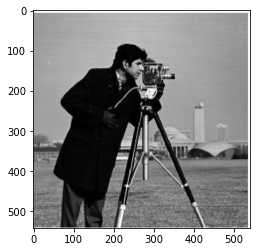

In [209]:
im = skio.imread('imgs/cameraman.png', as_gray=True)
im = sk.img_as_float(im)
plt.imshow(im, cmap='gray')

In [210]:
# Compute partial derivatives and gradient magnitude image 

dx = np.array([[1,-1]])
dy = np.array([[1],[-1]])

def get_derivatives(im):
    dx_img = convolve2d(im, dx, mode='same')
    dy_img = convolve2d(im, dy, mode='same')
    gradient_img = np.sqrt(np.square(dx_img) + np.square(dy_img))
    return dx_img, dy_img, gradient_img

dx_img, dy_img, gradient_img = get_derivatives(im)

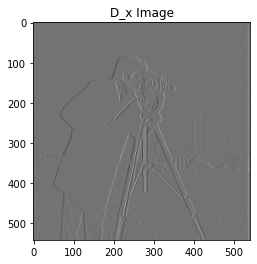

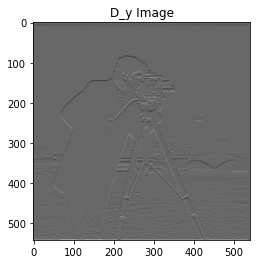

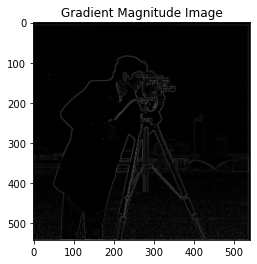

In [211]:
# Show images
plt.figure()
plt.title("D_x Image")
plt.imshow(dx_img, cmap='gray')
plt.savefig('outputs/filters/dx.jpg', bbox_inches='tight')
plt.figure()
plt.title("D_y Image")
plt.imshow(dy_img, cmap='gray')
plt.savefig('outputs/filters/dy.jpg', bbox_inches='tight')
plt.figure()
plt.title("Gradient Magnitude Image")
plt.imshow(gradient_img, cmap='gray')
plt.savefig('outputs/filters/gradmag.jpg', bbox_inches='tight')

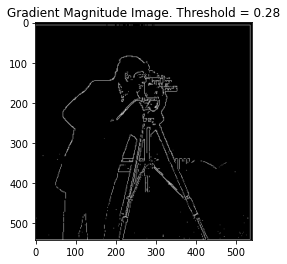

In [213]:
# Compute thresholded image
threshold = 0.28
gradient_img_thresholded = gradient_img > threshold

plt.figure()
plt.title(f"Gradient Magnitude Image. Threshold = {threshold}")
plt.imshow(gradient_img_thresholded, cmap='gray')
plt.savefig('outputs/filters/gradmag_thresholded.jpg', bbox_inches='tight')


### Part 1.2 - Derivative of Gaussian (DoG) Filter

In [214]:
def get_gaussian(l=5, sigma=1):
    # Create a gaussian kernel
    kernel_1d = gaussian(l, std=sigma).reshape(l, 1)
    kernel_2d = np.outer(kernel_1d, kernel_1d)
    return kernel_2d

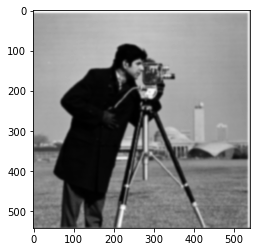

In [215]:
# Blur original image and rerun
g_l = 15
g_s = 2
gaussian_kernel = get_gaussian(g_l, g_s)
blurred_img = convolve2d(im, gaussian_kernel, mode='same')
plt.imshow(blurred_img, cmap='gray')
dx_img, dy_img, gradient_img = get_derivatives(blurred_img)

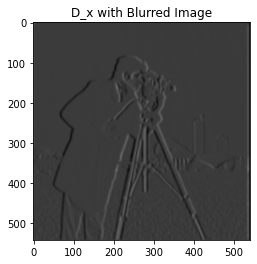

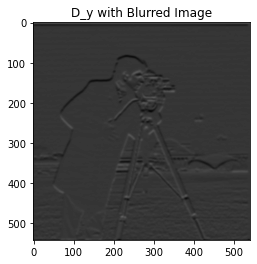

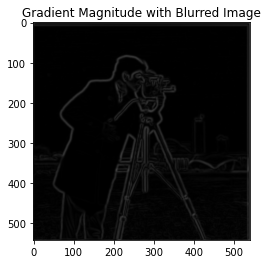

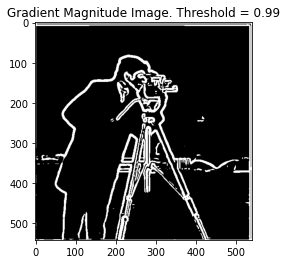

In [216]:
# Show images
plt.figure()
plt.title("D_x with Blurred Image")
plt.imshow(dx_img, cmap='gray')
plt.figure()
plt.title("D_y with Blurred Image")
plt.imshow(dy_img, cmap='gray')
plt.figure()
plt.title("Gradient Magnitude with Blurred Image")
plt.imshow(gradient_img, cmap='gray')

threshold = 0.99
gradient_img_thresholded = gradient_img > threshold

plt.figure()
plt.title(f"Gradient Magnitude Image. Threshold = {threshold}")
plt.imshow(gradient_img_thresholded, cmap='gray')
plt.savefig('outputs/filters/gradmag_gauss_thresholded.jpg', bbox_inches='tight')

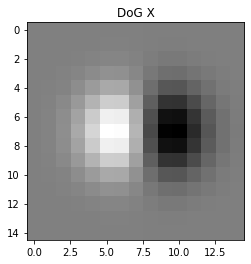

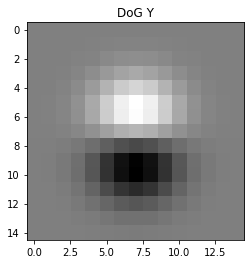

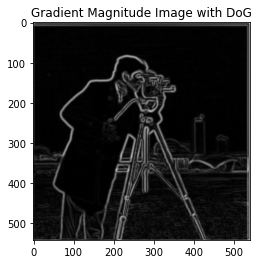

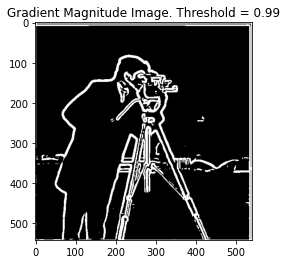

In [217]:
# Create DoG filters
dog_x = convolve2d(gaussian_kernel, dx, mode='same')
dog_y = convolve2d(gaussian_kernel, dy, mode='same')

# Visualize DoG
plt.figure()
plt.title('DoG X')
plt.imshow(dog_x, cmap='gray')
plt.savefig('outputs/filters/dog_x.jpg', bbox_inches='tight')

plt.figure()
plt.title('DoG Y')
plt.imshow(dog_y, cmap='gray')
plt.savefig('outputs/filters/dog_y.jpg', bbox_inches='tight')

# Compute gradient Image
gaussian_dx_img = convolve2d(im, dog_x, mode='same')
gaussian_dy_img = convolve2d(im, dog_y, mode='same')
gradient_img = np.sqrt(np.square(gaussian_dx_img) + np.square(gaussian_dy_img))

# plt.title("D_x with Blurred Image")
# plt.imshow(gaussian_dx_img, cmap='gray')
# plt.figure()
# plt.title("D_y with Blurred Image")
# plt.imshow(gaussian_dy_img, cmap='gray')

plt.figure()
plt.title("Gradient Magnitude Image with DoG")
plt.imshow(gradient_img, cmap='gray')

threshold = 0.99
gradient_img_thresholded = gradient_img > threshold

plt.figure()
plt.title(f"Gradient Magnitude Image. Threshold = {threshold}")
plt.imshow(gradient_img_thresholded, cmap='gray')
plt.savefig('outputs/filters/gradmag_dog_thresholded.jpg', bbox_inches='tight')

## Part 1.3

In [218]:
# Compute a score for the "straightness"
def get_score(img):
    gaussian_dx_img = convolve2d(img, dog_x, mode='same')
    gaussian_dy_img = convolve2d(img, dog_y, mode='same')
    angles = np.degrees(np.arctan2(gaussian_dy_img,gaussian_dx_img))
#     plt.figure()
#     plt.imshow(gaussian_dy_img, cmap='gray')
#     plt.figure()
#     plt.imshow(gaussian_dx_img, cmap='gray')
    bins = np.linspace(-180,180,181)
    hist_data, bins = np.histogram(angles.reshape(-1), bins=bins)
    
    # Get ideal distribution - max values at 0, 180, -180, 90, -90
    ideal = np.zeros_like(hist_data)
    idxs = np.where((bins==90) | (bins==-90))[0]
    idxs = np.concatenate([idxs, idxs + 1, idxs - 1, [0, len(hist_data)-1]]) # Add neighbor bins and 180 and -180
    ideal[idxs] = 1
    
    # Get "score"
    score = np.dot(ideal, hist_data)    
    return score

def crop_center(img, fraction=0.5):
    y, x, _ = img.shape
    x_len = int(x*fraction)
    y_len = int(y*fraction)
    startx = x//2-(x_len//2)
    starty = y//2-(y_len//2)    
    return img[starty:starty+y_len,startx:startx+x_len]

-20.0 4721
-17.894736842105264 4998
-15.789473684210527 5269
-13.68421052631579 5788
-11.578947368421053 6289
-9.473684210526317 6792
-7.368421052631579 7573
-5.2631578947368425 7799
-3.157894736842106 6986
-1.05263157894737 5781
1.0526315789473664 4942
3.1578947368421026 4621
5.2631578947368425 4537
7.368421052631579 4332
9.473684210526315 4063
11.578947368421051 3894
13.684210526315788 3805
15.789473684210527 3903
17.89473684210526 3808
20.0 3740
Best Angle: -5.2631578947368425, score = 3740


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-20.0 8160
-17.894736842105264 8115
-15.789473684210527 7979
-13.68421052631579 7899
-11.578947368421053 7834
-9.473684210526317 7716
-7.368421052631579 7708
-5.2631578947368425 7509
-3.157894736842106 7372
-1.05263157894737 7017
1.0526315789473664 7221
3.1578947368421026 7857
5.2631578947368425 9217
7.368421052631579 10713
9.473684210526315 11571
11.578947368421051 10952
13.684210526315788 9827
15.789473684210527 9164
17.89473684210526 8941
20.0 8904
Best Angle: 9.473684210526315, score = 8904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-20.0 6459
-17.894736842105264 6211
-15.789473684210527 5890
-13.68421052631579 5493
-11.578947368421053 5356
-9.473684210526317 5117
-7.368421052631579 4872
-5.2631578947368425 4826
-3.157894736842106 4698
-1.05263157894737 4668
1.0526315789473664 5125
3.1578947368421026 5701
5.2631578947368425 6614
7.368421052631579 7035
9.473684210526315 6795
11.578947368421051 6177
13.684210526315788 5729
15.789473684210527 5473
17.89473684210526 5273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20.0 5090
Best Angle: 7.368421052631579, score = 5090
-20.0 8261
-17.894736842105264 8462
-15.789473684210527 8404
-13.68421052631579 8498
-11.578947368421053 8377
-9.473684210526317 7973
-7.368421052631579 7914
-5.2631578947368425 7486
-3.157894736842106 7074
-1.05263157894737 6470
1.0526315789473664 6377
3.1578947368421026 6647
5.2631578947368425 6870
7.368421052631579 7081
9.473684210526315 7355
11.578947368421051 7756
13.684210526315788 7915
15.789473684210527 7717
17.89473684210526 7573


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20.0 7246
Best Angle: -13.68421052631579, score = 7246


<Figure size 432x288 with 0 Axes>

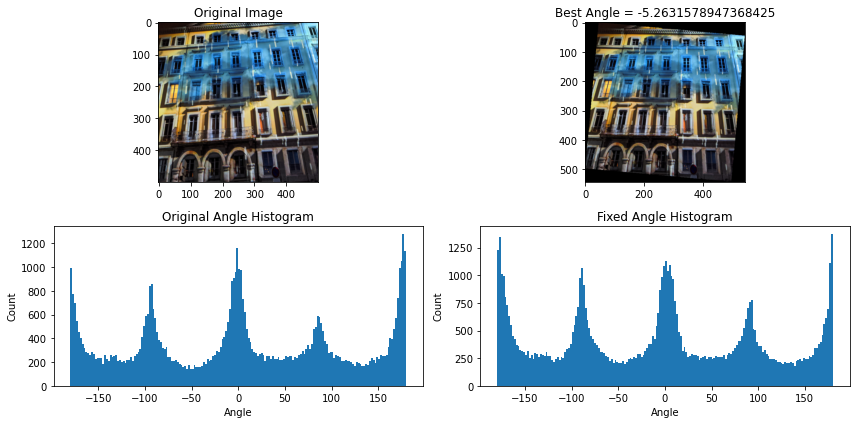

<Figure size 432x288 with 0 Axes>

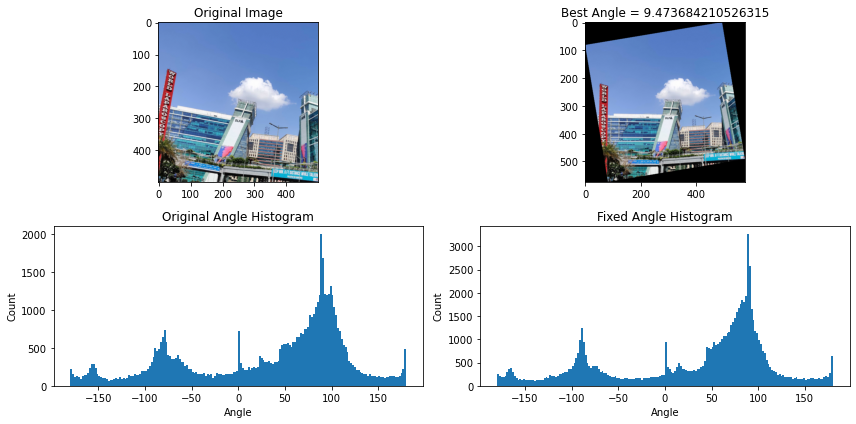

<Figure size 432x288 with 0 Axes>

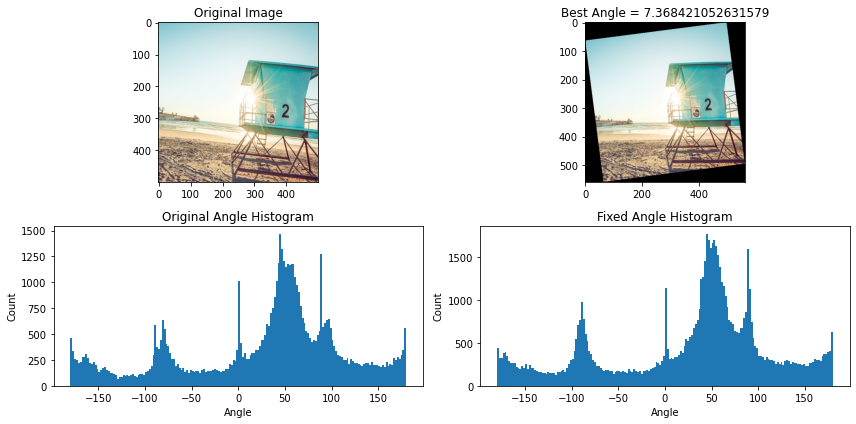

<Figure size 432x288 with 0 Axes>

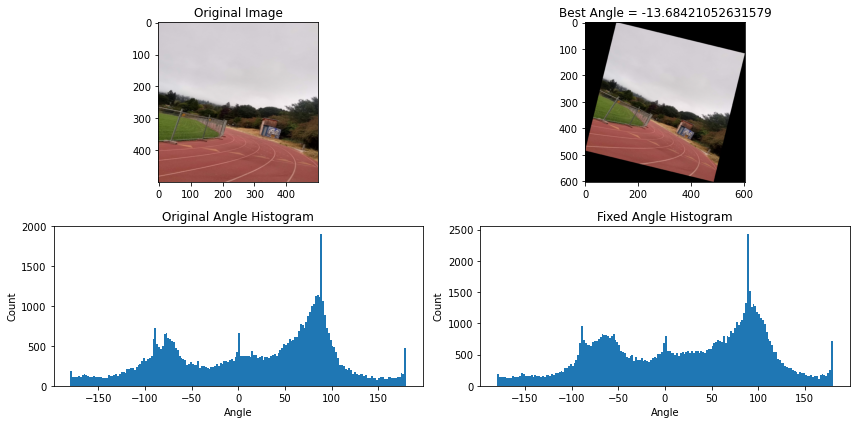

In [226]:
angles = np.linspace(-20,20,20)

def plot_hist(img, ax):
    gaussian_dx_img = convolve2d(img, dog_x, mode='same')
    gaussian_dy_img = convolve2d(img, dog_y, mode='same')
    angles = np.degrees(np.arctan2(gaussian_dy_img,gaussian_dx_img))
    bins = np.linspace(-180,180,181)
    ax.hist(angles.reshape(-1), bins=bins)

images = ['imgs/facade.jpg', 'imgs/bldg.jpg', 'imgs/beach.jpg', 'imgs/race_track.jpg']
for img_path in images:
    im = skio.imread(img_path)
    im = resize(im, (500,500),anti_aliasing=True) # Resize to speed up computation
    im = sk.img_as_float(im)
    im_roi = rgb2gray(crop_center(im))

    max_score = 0
    best_angle = 0
    for angle in angles:
        im_rotated = rotate(im, angle)
        im_roi = rgb2gray(crop_center(im_rotated))
        score = get_score(im_roi)
        print(angle, score)
        if score > max_score:
            max_score = score
            best_angle = angle

    print("Best Angle: {}, score = {}".format(best_angle, score))
    
    plt.figure()
    nrow = 2; ncol = 2;
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12,6))
    axs = axs.reshape(-1)
    
    ax = axs[0]
    ax.set_title('Original Image')
    ax.imshow(im)
    
    ax = axs[1]
    ax.set_title('Best Angle = {}'.format(best_angle))
    im_rotated = rotate(im, best_angle)
    ax.imshow(im_rotated)
    
    ax = axs[2]
    ax.set_title('Original Angle Histogram'.format(best_angle))
    ax.set_xlabel('Angle')
    ax.set_ylabel('Count')
    plot_hist(rgb2gray(crop_center(im)), ax)
    
    ax = axs[3]
    ax.set_title('Fixed Angle Histogram'.format(best_angle))
    ax.set_xlabel('Angle')
    ax.set_ylabel('Count')
    plot_hist(rgb2gray(crop_center(im_rotated)), ax)
    
    
    name = os.path.splitext(os.path.basename(img_path))[0]
    out_filename = name + '.jpg'
    out_path = os.path.join('outputs/straight/', out_filename)
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches='tight')